# Brain Tumor Detection
## Resnet101 - Classifier + Regressor
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-25 16:52:19.107199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742921539.116024   21725 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742921539.118457   21725 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742921539.127709   21725 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742921539.127722   21725 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742921539.127724   21725 computation_placer.cc:177] computation placer alr

In [3]:
# Mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [5]:
from src.data_handler.data_loader import DataLoader
from src.data_handler.annotation_processor import AnnotationProcessor
from src.data_handler.preprocessor import Preprocessor

In [6]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [7]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/-Brain-Tumor-Detection-2/train/


In [8]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [9]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)
OUTPUT_DIR = Path(cfg.OUTPUTS.OUTPUT_DIR)

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(CLASS_NAME)

## Dataset Download from Roboflow

In [10]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("yousef-ghanem-jzj4y").project("brain-tumor-detection-fpf1f")
    version = project.version(2)
    dataset = version.download("tensorflow") 

## Load images from directory

In [11]:
prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(6851, 6851, 6851)

In [12]:
train_bboxes[0], '--------------------', train_class_ids[:5]

(array([[0.68345324, 0.54545455, 0.95683453, 0.76515152],
        [0.42446043, 0.48484848, 0.99280576, 0.96969697],
        [0.46043165, 0.53030303, 0.99280576, 0.78030303]]),
 '--------------------',
 [[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [1]])

In [13]:
train_dl = DataLoader(train_images, train_class_ids, train_bboxes)
train_ds = train_dl.load_train_dataset()
train_ds = Preprocessor(train_ds).preprocess()
train_ds = train_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

I0000 00:00:1742921552.856357   21725 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7491 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [14]:
for batch in train_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(image[1].numpy().min(), image[1].numpy().max())
    print(cls[:5]) 


(64, 240, 240, 3) (64, 3) (64, 3, 4)
-123.7 125.2
tf.Tensor(
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]
 [1. 1. 1.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)


2025-03-25 16:52:40.922959: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets setup

In [15]:
prepare_valid_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))

valid_image_paths, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(1963, 1963, 1963)

In [16]:
valid_dl = DataLoader(valid_image_paths, valid_class_ids, valid_bboxes).load_val_dataset()
valid_ds = Preprocessor(valid_dl).preprocess()
valid_ds = valid_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [17]:
for batch in valid_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(image[1].numpy().min(), image[1].numpy().max())

(64, 240, 240, 3) (64, 3) (64, 3, 4)
-123.68 138.49847


2025-03-25 16:52:42.189171: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training Setup

## Define loss

In [18]:
padded_class_ids = train_dl.multi_hot_class_ids
padded_class_ids[:5]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 1., 0.]], dtype=float32)

In [19]:
from src.losses import binary_weighted_loss as _loss

positive_weights, negative_weights = _loss.compute_class_weights(padded_class_ids)
positive_weights, negative_weights 

(array([0.38140417, 0.01547219, 0.40767771]),
 array([0.61859584, 0.9845278 , 0.5923223 ], dtype=float32))

## Define ResNet50 Model

### Final Model

In [20]:
from src.losses import iou_loss
CLS_METRICS = [
    tf.keras.metrics.AUC(name='AUC', multi_label=True), 
    tf.keras.metrics.F1Score(name='f1_score',average='weighted')]


REG_METRICS = [
    iou_loss.iou_metric,
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae')]

### Define  Callbacks

In [21]:
import os
import mlflow

mlflow_exp = mlflow.set_experiment("/brain-tumor-resnet101-phase-training")

2025/03/25 16:52:44 INFO mlflow.tracking.fluent: Experiment with name '/brain-tumor-resnet101-phase-training' does not exist. Creating a new experiment.


### Define Optimizer

## Model Building and Compilation

In [22]:
class MultiTaskLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.7, beta=0.3):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        
    def call(self, y_true, y_pred):
        cls_loss = _loss.set_binary_crossentropy_weighted_loss(
            positive_weights, negative_weights)(y_true[0], y_pred[0])
        box_loss = iou_loss.iou_loss(y_true[1], y_pred[1])
        return self.alpha * cls_loss + self.beta * box_loss

### Train and Validate the model

### Phase 1: Train feature extractor with Regressor head

In [23]:
run = mlflow.start_run() 
to_monitor = 'val_bounding_box_iou_metric'
mode = 'max'
mlflow.tensorflow.autolog(log_models=True, 
                        log_datasets=False, 
                        log_input_examples=True,
                        log_model_signatures=True,
                        keras_model_kwargs={"save_format": "keras"},
                        checkpoint_monitor=to_monitor, 
                        checkpoint_mode=mode)

2025/03/25 16:52:44 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


In [24]:
from src.models.resnet101V2 import final_model

model = final_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

In [25]:
# Freeze regression branch and feature extractor
for layer in model.layers:
    # Freeze classification-specific layers
    if 'classification' in layer.name:
        print(layer.name)
        layer.trainable = False
    # Explicitly keep regression/basemodel trainable
    else:
        layer.trainable = True

classification_dense_256
classification


In [26]:
# Only enable classification training
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4),
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box':  iou_loss.iou_loss},
    metrics={'classification': [tf.keras.metrics.F1Score(name='f1_score',average='weighted')], 
             'bounding_box': REG_METRICS},
    loss_weights={'classification': 0.0, 'bounding_box': 2.0})
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 240, 240,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ cast[0][0]        │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 60, 60,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 60, 60,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 62, 62,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r

 Total params: 45,940,623 (175.25 MB)

 Trainable params: 45,317,644 (172.87 MB)

 Non-trainable params: 622,979 (2.38 MB)

In [27]:
to_monitor = 'val_bounding_box_iou_metric'
mode = 'max'
phase1_epoch = 50
history_ph1 = model.fit(
    train_ds,
    epochs=phase1_epoch,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[ReduceLROnPlateau(factor=0.1, 
                                patience=3, 
                                monitor=to_monitor,
                                mode=mode,
                                min_lr=1e-7,
                                verbose=1), 
                ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "phase1.weights.h5") ,
                                save_weights_only=True,
                                save_best_only=False,
                                monitor=to_monitor,
                                mode=mode,
                                verbose=1),
                EarlyStopping(monitor=to_monitor, 
                            patience=5,
                            mode=mode, 
                            restore_best_weights=True,
                            verbose=1)])

Epoch 1/50


I0000 00:00:1742921605.405078   22076 service.cc:152] XLA service 0x749c0c002850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742921605.405109   22076 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-25 16:53:26.411149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742921612.931513   22076 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-25 16:53:42.564533: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-filter.105 = (f16[64,7,7,4]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,240,240,4]{3,2,1,0} %bitcast.128501, f16[64,120,120,64]{3,2,1,0} %bitcast.138911), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBa

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - bounding_box_iou_metric: 0.1375 - bounding_box_loss: 0.8627 - bounding_box_mae: 0.2928 - bounding_box_mse: 0.1460 - classification_f1_score: 0.3932 - classification_loss: 0.7412 - loss: 1.7253
Epoch 1: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 142s 558ms/step - bounding_box_iou_metric: 0.1381 - bounding_box_loss: 0.8621 - bounding_box_mae: 0.2926 - bounding_box_mse: 0.1458 - classification_f1_score: 0.3931 - classification_loss: 0.7409 - loss: 1.7242 - val_bounding_box_iou_metric: 0.1007 - val_bounding_box_loss: 0.8996 - val_bounding_box_mae: 0.3405 - val_bounding_box_mse: 0.1865 - val_classification_f1_score: 0.3773 - val_classification_loss: 0.6821 - val_loss: 1.7990 - learning_rate: 3.0000e-04
Epoch 2/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - bounding_box_iou_metric: 0.2937 - bounding_box_loss: 0.7067 - bounding_box_mae: 0.2342 - bounding_box_mse: 0.1154 - classification_f1_score: 0.3605 - classification_loss: 0.7040 - loss: 1.4135
Epoch 2: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - bounding_box_iou_metric: 0.2942 - bounding_box_loss: 0.7062 - bounding_box_mae: 0.2339 - bounding_box_mse: 0.1153 - classification_f1_score: 0.3605 - classification_loss: 0.7039 - loss: 1.4125 - val_bounding_box_iou_metric: 0.3035 - val_bounding_box_loss: 0.6969 - val_bounding_box_mae: 0.2515 - val_bounding_box_mse: 0.1317 - val_classification_f1_score: 0.2257 - val_classification_loss: 0.6913 - val_loss: 1.3935 - learning_rate: 3.0000e-04
Epoch 3/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - bounding_box_iou_metric: 0.3562 - bounding_box_loss: 0.6440 - bounding_box_mae: 0.2072 - bounding_box_mse: 0.0989 - classification_f1_score: 0.3576 - classification_loss: 0.6950 - loss: 1.2879
Epoch 3: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - bounding_box_iou_metric: 0.3563 - bounding_box_loss: 0.6438 - bounding_box_mae: 0.2072 - bounding_box_mse: 0.0989 - classification_f1_score: 0.3577 - classification_loss: 0.6950 - loss: 1.2876 - val_bounding_box_iou_metric: 0.3889 - val_bounding_box_loss: 0.6117 - val_bounding_box_mae: 0.2042 - val_bounding_box_mse: 0.1020 - val_classification_f1_score: 0.2516 - val_classification_loss: 0.6756 - val_loss: 1.2231 - learning_rate: 3.0000e-04
Epoch 4/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - bounding_box_iou_metric: 0.3849 - bounding_box_loss: 0.6157 - bounding_box_mae: 0.2054 - bounding_box_mse: 0.1019 - classification_f1_score: 0.3857 - classification_loss: 0.6900 - loss: 1.2314
Epoch 4: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - bounding_box_iou_metric: 0.3850 - bounding_box_loss: 0.6155 - bounding_box_mae: 0.2053 - bounding_box_mse: 0.1019 - classification_f1_score: 0.3857 - cla

108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - bounding_box_iou_metric: 0.3949 - bounding_box_loss: 0.6057 - bounding_box_mae: 0.2018 - bounding_box_mse: 0.0990 - classification_f1_score: 0.3738 - classification_loss: 0.6860 - loss: 1.2112 - val_bounding_box_iou_metric: 0.4189 - val_bounding_box_loss: 0.5816 - val_bounding_box_mae: 0.2125 - val_bounding_box_mse: 0.1150 - val_classification_f1_score: 0.2809 - val_classification_loss: 0.6706 - val_loss: 1.1628 - learning_rate: 3.0000e-04
Epoch 7/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - bounding_box_iou_metric: 0.4108 - bounding_box_loss: 0.5895 - bounding_box_mae: 0.2068 - bounding_box_mse: 0.1070 - classification_f1_score: 0.3709 - classification_loss: 0.6866 - loss: 1.1790
Epoch 7: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - bounding_box_iou_metric: 0.4109 - bounding_box_loss: 0.5894 - bounding_box_mae: 0.2066 - bounding_box_mse: 0.1069 - classification_f1_score: 0.3710 - classification_loss: 0.6865 - loss: 1.1788 - val_bounding_box_iou_metric: 0.4415 - val_bounding_box_loss: 0.5586 - val_bounding_box_mae: 0.1849 - val_bounding_box_mse: 0.0888 - val_classification_f1_score: 0.3399 - val_classification_loss: 0.6749 - val_loss: 1.1172 - learning_rate: 3.0000e-04
Epoch 8/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - bounding_box_iou_metric: 0.4298 - bounding_box_loss: 0.5705 - bounding_box_mae: 0.1986 - bounding_box_mse: 0.1003 - classification_f1_score: 0.3821 - classification_loss: 0.6870 - loss: 1.1410
Epoch 8: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 170ms/step - bounding_box_iou_metric: 0.4298 - bounding_box_loss: 0.5705 - bounding_box_mae: 0.1986 - bounding_box_mse: 0.1003 - classification_f1_score: 0.3822 - cla

108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - bounding_box_iou_metric: 0.4525 - bounding_box_loss: 0.5480 - bounding_box_mae: 0.1920 - bounding_box_mse: 0.0982 - classification_f1_score: 0.3792 - classification_loss: 0.6829 - loss: 1.0960 - val_bounding_box_iou_metric: 0.4553 - val_bounding_box_loss: 0.5451 - val_bounding_box_mae: 0.1853 - val_bounding_box_mse: 0.0922 - val_classification_f1_score: 0.3454 - val_classification_loss: 0.6747 - val_loss: 1.0896 - learning_rate: 3.0000e-04
Epoch 11/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - bounding_box_iou_metric: 0.4478 - bounding_box_loss: 0.5525 - bounding_box_mae: 0.1925 - bounding_box_mse: 0.0981 - classification_f1_score: 0.3808 - classification_loss: 0.6857 - loss: 1.1050
Epoch 11: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - bounding_box_iou_metric: 0.4480 - bounding_box_loss: 0.5524 - bounding_box_mae: 0.1925 - bounding_box_mse: 0.0981 - classification_f1_score: 0.3808 - classification_loss: 0.6858 - loss: 1.1047 - val_bounding_box_iou_metric: 0.4860 - val_bounding_box_loss: 0.5142 - val_bounding_box_mae: 0.1797 - val_bounding_box_mse: 0.0909 - val_classification_f1_score: 0.3348 - val_classification_loss: 0.6734 - val_loss: 1.0281 - learning_rate: 3.0000e-04
Epoch 12/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - bounding_box_iou_metric: 0.4664 - bounding_box_loss: 0.5339 - bounding_box_mae: 0.1858 - bounding_box_mse: 0.0941 - classification_f1_score: 0.3841 - classification_loss: 0.6843 - loss: 1.0678
Epoch 12: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - bounding_box_iou_metric: 0.4664 - bounding_box_loss: 0.5339 - bounding_box_mae: 0.1858 - bounding_box_mse: 0.0942 - classification_f1_score: 0.3842 - c

108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - bounding_box_iou_metric: 0.4994 - bounding_box_loss: 0.5007 - bounding_box_mae: 0.1832 - bounding_box_mse: 0.0965 - classification_f1_score: 0.3843 - classification_loss: 0.6818 - loss: 1.0013 - val_bounding_box_iou_metric: 0.5266 - val_bounding_box_loss: 0.4735 - val_bounding_box_mae: 0.1740 - val_bounding_box_mse: 0.0894 - val_classification_f1_score: 0.3438 - val_classification_loss: 0.6746 - val_loss: 0.9471 - learning_rate: 3.0000e-05
Epoch 16/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - bounding_box_iou_metric: 0.5226 - bounding_box_loss: 0.4777 - bounding_box_mae: 0.1811 - bounding_box_mse: 0.0956 - classification_f1_score: 0.3820 - classification_loss: 0.6874 - loss: 0.9554
Epoch 16: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - bounding_box_iou_metric: 0.5226 - bounding_box_loss: 0.4777 - bounding_box_mae: 0.1811 - bounding_box_mse: 0.0956 - classification_f1_score: 0.3820 - classification_loss: 0.6873 - loss: 0.9554 - val_bounding_box_iou_metric: 0.5319 - val_bounding_box_loss: 0.4683 - val_bounding_box_mae: 0.1722 - val_bounding_box_mse: 0.0885 - val_classification_f1_score: 0.3503 - val_classification_loss: 0.6742 - val_loss: 0.9366 - learning_rate: 3.0000e-05
Epoch 17/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - bounding_box_iou_metric: 0.5292 - bounding_box_loss: 0.4711 - bounding_box_mae: 0.1811 - bounding_box_mse: 0.0962 - classification_f1_score: 0.3730 - classification_loss: 0.6868 - loss: 0.9421
Epoch 17: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - bounding_box_iou_metric: 0.5291 - bounding_box_loss: 0.4711 - bounding_box_mae: 0.1811 - bounding_box_mse: 0.0961 - classification_f1_score: 0.3731 - classification_loss: 0.6868 - loss: 0.9421 - val_bounding_box_iou_metric: 0.5365 - val_bounding_box_loss: 0.4637 - val_bounding_box_mae: 0.1706 - val_bounding_box_mse: 0.0875 - val_classification_f1_score: 0.3503 - val_classification_loss: 0.6745 - val_loss: 0.9274 - learning_rate: 3.0000e-05
Epoch 18/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - bounding_box_iou_metric: 0.5333 - bounding_box_loss: 0.4672 - bounding_box_mae: 0.1753 - bounding_box_mse: 0.0919 - classification_f1_score: 0.3825 - classification_loss: 0.6819 - loss: 0.9344
Epoch 18: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - bounding_box_iou_metric: 0.5333 - bounding_box_loss: 0.4672 - bounding_box_mae: 0.1753 - bounding_box_mse: 0.0919 - classification_f1_score: 0.3824 - classification_loss: 0.6819 - loss: 0.9343 - val_bounding_box_iou_metric: 0.5382 - val_bounding_box_loss: 0.4618 - val_bounding_box_mae: 0.1724 - val_bounding_box_mse: 0.0894 - val_classification_f1_score: 0.3426 - val_classification_loss: 0.6744 - val_loss: 0.9238 - learning_rate: 3.0000e-05
Epoch 19/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - bounding_box_iou_metric: 0.5383 - bounding_box_loss: 0.4622 - bounding_box_mae: 0.1747 - bounding_box_mse: 0.0921 - classification_f1_score: 0.3765 - classification_loss: 0.6820 - loss: 0.9245
Epoch 19: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - bounding_box_iou_metric: 0.5383 - bounding_box_loss: 0.4623 - bounding_box_mae: 0.1747 - bounding_box_mse: 0.0921 - classification_f1_score: 0.3765 - classification_loss: 0.6821 - loss: 0.9245 - val_bounding_box_iou_metric: 0.5437 - val_bounding_box_loss: 0.4565 - val_bounding_box_mae: 0.1715 - val_bounding_box_mse: 0.0893 - val_classification_f1_score: 0.3435 - val_classification_loss: 0.6741 - val_loss: 0.9130 - learning_rate: 3.0000e-05
Epoch 20/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - bounding_box_iou_metric: 0.5422 - bounding_box_loss: 0.4580 - bounding_box_mae: 0.1762 - bounding_box_mse: 0.0934 - classification_f1_score: 0.3821 - classification_loss: 0.6847 - loss: 0.9159
Epoch 20: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - bounding_box_iou_metric: 0.5422 - bounding_box_loss: 0.4580 - bounding_box_mae: 0.1762 - bounding_box_mse: 0.0934 - classification_f1_score: 0.3820 - classification_loss: 0.6847 - loss: 0.9159 - val_bounding_box_iou_metric: 0.5460 - val_bounding_box_loss: 0.4542 - val_bounding_box_mae: 0.1728 - val_bounding_box_mse: 0.0911 - val_classification_f1_score: 0.3269 - val_classification_loss: 0.6740 - val_loss: 0.9083 - learning_rate: 3.0000e-05
Epoch 21/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - bounding_box_iou_metric: 0.5497 - bounding_box_loss: 0.4507 - bounding_box_mae: 0.1759 - bounding_box_mse: 0.0936 - classification_f1_score: 0.3761 - classification_loss: 0.6837 - loss: 0.9013
Epoch 21: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - bounding_box_iou_metric: 0.5497 - bounding_box_loss: 0.4508 - bounding_box_mae: 0.1759 - bounding_box_mse: 0.0936 - classification_f1_score: 0.3760 - classification_loss: 0.6837 - loss: 0.9015 - val_bounding_box_iou_metric: 0.5479 - val_bounding_box_loss: 0.4523 - val_bounding_box_mae: 0.1710 - val_bounding_box_mse: 0.0893 - val_classification_f1_score: 0.3223 - val_classification_loss: 0.6738 - val_loss: 0.9047 - learning_rate: 3.0000e-05
Epoch 22/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - bounding_box_iou_metric: 0.5443 - bounding_box_loss: 0.4558 - bounding_box_mae: 0.1777 - bounding_box_mse: 0.0940 - classification_f1_score: 0.3746 - classification_loss: 0.6863 - loss: 0.9116
Epoch 22: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 174ms/step - bounding_box_iou_metric: 0.5443 - bounding_box_loss: 0.4558 - bounding_box_mae: 0.1777 - bounding_box_mse: 0.0939 - classification_f1_score: 0.3746 - classification_loss: 0.6862 - loss: 0.9115 - val_bounding_box_iou_metric: 0.5498 - val_bounding_box_loss: 0.4504 - val_bounding_box_mae: 0.1713 - val_bounding_box_mse: 0.0897 - val_classification_f1_score: 0.3240 - val_classification_loss: 0.6737 - val_loss: 0.9009 - learning_rate: 3.0000e-05
Epoch 23/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - bounding_box_iou_metric: 0.5511 - bounding_box_loss: 0.4493 - bounding_box_mae: 0.1768 - bounding_box_mse: 0.0950 - classification_f1_score: 0.3635 - classification_loss: 0.6851 - loss: 0.8986
Epoch 23: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - bounding_box_iou_metric: 0.5511 - bounding_box_loss: 0.4493 - bounding_box_mae: 0.1768 - bounding_box_mse: 0.0950 - classification_f1_score: 0.3635 - classification_loss: 0.6851 - loss: 0.8986 - val_bounding_box_iou_metric: 0.5512 - val_bounding_box_loss: 0.4490 - val_bounding_box_mae: 0.1695 - val_bounding_box_mse: 0.0882 - val_classification_f1_score: 0.3159 - val_classification_loss: 0.6744 - val_loss: 0.8980 - learning_rate: 3.0000e-05
Epoch 24/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.5568 - bounding_box_loss: 0.4434 - bounding_box_mae: 0.1743 - bounding_box_mse: 0.0924 - classification_f1_score: 0.3668 - classification_loss: 0.6850 - loss: 0.8869
Epoch 24: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - bounding_box_iou_metric: 0.5567 - bounding_box_loss: 0.4435 - bounding_box_mae: 0.1743 - bounding_box_mse: 0.0924 - classification_f1_score: 0.3669 - classification_loss: 0.6850 - loss: 0.8870 - val_bounding_box_iou_metric: 0.5524 - val_bounding_box_loss: 0.4478 - val_bounding_box_mae: 0.1722 - val_bounding_box_mse: 0.0911 - val_classification_f1_score: 0.3108 - val_classification_loss: 0.6735 - val_loss: 0.8956 - learning_rate: 3.0000e-05
Epoch 25/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - bounding_box_iou_metric: 0.5603 - bounding_box_loss: 0.4397 - bounding_box_mae: 0.1723 - bounding_box_mse: 0.0921 - classification_f1_score: 0.3760 - classification_loss: 0.6812 - loss: 0.8795
Epoch 25: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - bounding_box_iou_metric: 0.5602 - bounding_box_loss: 0.4398 - bounding_box_mae: 0.1723 - bounding_box_mse: 0.0921 - classification_f1_score: 0.3759 - classification_loss: 0.6812 - loss: 0.8796 - val_bounding_box_iou_metric: 0.5574 - val_bounding_box_loss: 0.4428 - val_bounding_box_mae: 0.1686 - val_bounding_box_mse: 0.0880 - val_classification_f1_score: 0.3138 - val_classification_loss: 0.6739 - val_loss: 0.8857 - learning_rate: 3.0000e-05
Epoch 26/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - bounding_box_iou_metric: 0.5591 - bounding_box_loss: 0.4409 - bounding_box_mae: 0.1737 - bounding_box_mse: 0.0929 - classification_f1_score: 0.3692 - classification_loss: 0.6829 - loss: 0.8819
Epoch 26: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - bounding_box_iou_metric: 0.5591 - bounding_box_loss: 0.4409 - bounding_box_mae: 0.1737 - bounding_box_mse: 0.0929 - classification_f1_score: 0.3692 - classification_loss: 0.6829 - loss: 0.8818 - val_bounding_box_iou_metric: 0.5610 - val_bounding_box_loss: 0.4393 - val_bounding_box_mae: 0.1681 - val_bounding_box_mse: 0.0877 - val_classification_f1_score: 0.3126 - val_classification_loss: 0.6737 - val_loss: 0.8786 - learning_rate: 3.0000e-05
Epoch 27/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.5604 - bounding_box_loss: 0.4397 - bounding_box_mae: 0.1740 - bounding_box_mse: 0.0926 - classification_f1_score: 0.3679 - classification_loss: 0.6859 - loss: 0.8794
Epoch 27: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - bounding_box_iou_metric: 0.5604 - bounding_box_loss: 0.4397 - bounding_box_mae: 0.1740 - bounding_box_mse: 0.0926 - classification_f1_score: 0.3680 - c

108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - bounding_box_iou_metric: 0.5666 - bounding_box_loss: 0.4334 - bounding_box_mae: 0.1762 - bounding_box_mse: 0.0951 - classification_f1_score: 0.3638 - classification_loss: 0.6873 - loss: 0.8667 - val_bounding_box_iou_metric: 0.5611 - val_bounding_box_loss: 0.4391 - val_bounding_box_mae: 0.1681 - val_bounding_box_mse: 0.0878 - val_classification_f1_score: 0.3073 - val_classification_loss: 0.6740 - val_loss: 0.8783 - learning_rate: 3.0000e-05
Epoch 30/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - bounding_box_iou_metric: 0.5725 - bounding_box_loss: 0.4277 - bounding_box_mae: 0.1706 - bounding_box_mse: 0.0910 - classification_f1_score: 0.3641 - classification_loss: 0.6846 - loss: 0.8555
Epoch 30: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - bounding_box_iou_metric: 0.5724 - bounding_box_loss: 0.4278 - bounding_box_mae: 0.1706 - bounding_box_mse: 0.0910 - classification_f1_score: 0.3642 - classification_loss: 0.6846 - loss: 0.8556 - val_bounding_box_iou_metric: 0.5644 - val_bounding_box_loss: 0.4359 - val_bounding_box_mae: 0.1691 - val_bounding_box_mse: 0.0887 - val_classification_f1_score: 0.3036 - val_classification_loss: 0.6734 - val_loss: 0.8717 - learning_rate: 3.0000e-05
Epoch 31/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.5701 - bounding_box_loss: 0.4302 - bounding_box_mae: 0.1711 - bounding_box_mse: 0.0916 - classification_f1_score: 0.3609 - classification_loss: 0.6814 - loss: 0.8604
Epoch 31: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - bounding_box_iou_metric: 0.5701 - bounding_box_loss: 0.4301 - bounding_box_mae: 0.1711 - bounding_box_mse: 0.0916 - classification_f1_score: 0.3608 - c

108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - bounding_box_iou_metric: 0.5713 - bounding_box_loss: 0.4289 - bounding_box_mae: 0.1731 - bounding_box_mse: 0.0933 - classification_f1_score: 0.3540 - classification_loss: 0.6858 - loss: 0.8577 - val_bounding_box_iou_metric: 0.5646 - val_bounding_box_loss: 0.4358 - val_bounding_box_mae: 0.1675 - val_bounding_box_mse: 0.0874 - val_classification_f1_score: 0.3043 - val_classification_loss: 0.6745 - val_loss: 0.8712 - learning_rate: 3.0000e-05
Epoch 34/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.5790 - bounding_box_loss: 0.4210 - bounding_box_mae: 0.1720 - bounding_box_mse: 0.0924 - classification_f1_score: 0.3596 - classification_loss: 0.6867 - loss: 0.8421
Epoch 34: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - bounding_box_iou_metric: 0.5790 - bounding_box_loss: 0.4211 - bounding_box_mae: 0.1720 - bounding_box_mse: 0.0924 - classification_f1_score: 0.3595 - c

108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - bounding_box_iou_metric: 0.5835 - bounding_box_loss: 0.4161 - bounding_box_mae: 0.1718 - bounding_box_mse: 0.0931 - classification_f1_score: 0.3582 - classification_loss: 0.6858 - loss: 0.8323 - val_bounding_box_iou_metric: 0.5685 - val_bounding_box_loss: 0.4319 - val_bounding_box_mae: 0.1653 - val_bounding_box_mse: 0.0857 - val_classification_f1_score: 0.2858 - val_classification_loss: 0.6744 - val_loss: 0.8635 - learning_rate: 3.0000e-05
Epoch 36/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.5855 - bounding_box_loss: 0.4148 - bounding_box_mae: 0.1710 - bounding_box_mse: 0.0921 - classification_f1_score: 0.3526 - classification_loss: 0.6849 - loss: 0.8296
Epoch 36: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - bounding_box_iou_metric: 0.5854 - bounding_box_loss: 0.4149 - bounding_box_mae: 0.1710 - bounding_box_mse: 0.0921 - classification_f1_score: 0.3526 - c

108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - bounding_box_iou_metric: 0.5845 - bounding_box_loss: 0.4157 - bounding_box_mae: 0.1705 - bounding_box_mse: 0.0920 - classification_f1_score: 0.3640 - classification_loss: 0.6855 - loss: 0.8314 - val_bounding_box_iou_metric: 0.5705 - val_bounding_box_loss: 0.4299 - val_bounding_box_mae: 0.1673 - val_bounding_box_mse: 0.0878 - val_classification_f1_score: 0.2905 - val_classification_loss: 0.6739 - val_loss: 0.8597 - learning_rate: 3.0000e-05
Epoch 39/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - bounding_box_iou_metric: 0.5893 - bounding_box_loss: 0.4108 - bounding_box_mae: 0.1692 - bounding_box_mse: 0.0911 - classification_f1_score: 0.3600 - classification_loss: 0.6849 - loss: 0.8215
Epoch 39: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - bounding_box_iou_metric: 0.5893 - bounding_box_loss: 0.4108 - bounding_box_mae: 0.1692 - bounding_box_mse: 0.0912 - classification_f1_score: 0.3599 - classification_loss: 0.6850 - loss: 0.8216 - val_bounding_box_iou_metric: 0.5709 - val_bounding_box_loss: 0.4295 - val_bounding_box_mae: 0.1661 - val_bounding_box_mse: 0.0866 - val_classification_f1_score: 0.2930 - val_classification_loss: 0.6744 - val_loss: 0.8588 - learning_rate: 3.0000e-05
Epoch 40/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.5910 - bounding_box_loss: 0.4092 - bounding_box_mae: 0.1713 - bounding_box_mse: 0.0934 - classification_f1_score: 0.3504 - classification_loss: 0.6864 - loss: 0.8183
Epoch 40: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - bounding_box_iou_metric: 0.5910 - bounding_box_loss: 0.4092 - bounding_box_mae: 0.1712 - bounding_box_mse: 0.0934 - classification_f1_score: 0.3505 - c

108/108 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - bounding_box_iou_metric: 0.5916 - bounding_box_loss: 0.4085 - bounding_box_mae: 0.1671 - bounding_box_mse: 0.0900 - classification_f1_score: 0.3488 - classification_loss: 0.6838 - loss: 0.8170 - val_bounding_box_iou_metric: 0.5742 - val_bounding_box_loss: 0.4261 - val_bounding_box_mae: 0.1678 - val_bounding_box_mse: 0.0888 - val_classification_f1_score: 0.2848 - val_classification_loss: 0.6739 - val_loss: 0.8521 - learning_rate: 3.0000e-05
Epoch 42/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.5938 - bounding_box_loss: 0.4064 - bounding_box_mae: 0.1684 - bounding_box_mse: 0.0912 - classification_f1_score: 0.3582 - classification_loss: 0.6848 - loss: 0.8127
Epoch 42: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 179ms/step - bounding_box_iou_metric: 0.5938 - bounding_box_loss: 0.4064 - bounding_box_mae: 0.1684 - bounding_box_mse: 0.0912 - classification_f1_score: 0.3582 - classification_loss: 0.6848 - loss: 0.8128 - val_bounding_box_iou_metric: 0.5750 - val_bounding_box_loss: 0.4255 - val_bounding_box_mae: 0.1674 - val_bounding_box_mse: 0.0885 - val_classification_f1_score: 0.2789 - val_classification_loss: 0.6737 - val_loss: 0.8507 - learning_rate: 3.0000e-05
Epoch 43/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.5948 - bounding_box_loss: 0.4053 - bounding_box_mae: 0.1700 - bounding_box_mse: 0.0922 - classification_f1_score: 0.3566 - classification_loss: 0.6858 - loss: 0.8105
Epoch 43: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - bounding_box_iou_metric: 0.5948 - bounding_box_loss: 0.4053 - bounding_box_mae: 0.1700 - bounding_box_mse: 0.0922 - classification_f1_score: 0.3566 - classification_loss: 0.6858 - loss: 0.8106 - val_bounding_box_iou_metric: 0.5760 - val_bounding_box_loss: 0.4245 - val_bounding_box_mae: 0.1657 - val_bounding_box_mse: 0.0872 - val_classification_f1_score: 0.2878 - val_classification_loss: 0.6745 - val_loss: 0.8488 - learning_rate: 3.0000e-05
Epoch 44/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.6002 - bounding_box_loss: 0.4005 - bounding_box_mae: 0.1707 - bounding_box_mse: 0.0928 - classification_f1_score: 0.3577 - classification_loss: 0.6879 - loss: 0.8009
Epoch 44: saving model to output/checkpoints/phase1.weights.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - bounding_box_iou_metric: 0.6001 - bounding_box_loss: 0.4005 - bounding_box_mae: 0.1707 - bounding_box_mse: 0.0928 - classification_f1_score: 0.3578 - classification_loss: 0.6879 - loss: 0.8010 - val_bounding_box_iou_metric: 0.5776 - val_bounding_box_loss: 0.4228 - val_bounding_box_mae: 0.1666 - val_bounding_box_mse: 0.0882 - val_classification_f1_score: 0.2938 - val_classification_loss: 0.6744 - val_loss: 0.8456 - learning_rate: 3.0000e-05
Epoch 45/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - bounding_box_iou_metric: 0.6006 - bounding_box_loss: 0.3995 - bounding_box_mae: 0.1710 - bounding_box_mse: 0.0931 - classification_f1_score: 0.3601 - classification_loss: 0.6871 - loss: 0.7991
Epoch 45: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - bounding_box_iou_metric: 0.6005 - bounding_box_loss: 0.3996 - bounding_box_mae: 0.1710 - bounding_box_mse: 0.0931 - classification_f1_score: 0.3601 - c

108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - bounding_box_iou_metric: 0.6052 - bounding_box_loss: 0.3949 - bounding_box_mae: 0.1669 - bounding_box_mse: 0.0901 - classification_f1_score: 0.3589 - classification_loss: 0.6871 - loss: 0.7897 - val_bounding_box_iou_metric: 0.5792 - val_bounding_box_loss: 0.4210 - val_bounding_box_mae: 0.1658 - val_bounding_box_mse: 0.0874 - val_classification_f1_score: 0.2938 - val_classification_loss: 0.6741 - val_loss: 0.8421 - learning_rate: 3.0000e-05
Epoch 48/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - bounding_box_iou_metric: 0.6034 - bounding_box_loss: 0.3968 - bounding_box_mae: 0.1676 - bounding_box_mse: 0.0916 - classification_f1_score: 0.3552 - classification_loss: 0.6831 - loss: 0.7937
Epoch 48: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - bounding_box_iou_metric: 0.6034 - bounding_box_loss: 0.3969 - bounding_box_mae: 0.1676 - bounding_box_mse: 0.0916 - classification_f1_score: 0.3552 - c

108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 179ms/step - bounding_box_iou_metric: 0.6009 - bounding_box_loss: 0.3992 - bounding_box_mae: 0.1697 - bounding_box_mse: 0.0927 - classification_f1_score: 0.3552 - classification_loss: 0.6862 - loss: 0.7983 - val_bounding_box_iou_metric: 0.5817 - val_bounding_box_loss: 0.4187 - val_bounding_box_mae: 0.1649 - val_bounding_box_mse: 0.0868 - val_classification_f1_score: 0.2815 - val_classification_loss: 0.6739 - val_loss: 0.8372 - learning_rate: 3.0000e-05
Epoch 50/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - bounding_box_iou_metric: 0.6045 - bounding_box_loss: 0.3955 - bounding_box_mae: 0.1684 - bounding_box_mse: 0.0916 - classification_f1_score: 0.3532 - classification_loss: 0.6851 - loss: 0.7910
Epoch 50: saving model to output/checkpoints/phase1.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 165ms/step - bounding_box_iou_metric: 0.6045 - bounding_box_loss: 0.3956 - bounding_box_mae: 0.1684 - bounding_box_mse: 0.0915 - classification_f1_score: 0.3533 - c

2025/03/25 17:16:23 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/03/25 17:16:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpm7xhgn2k/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/25 17:16:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


### Phase 2: Freeze classification head and train classifier head

In [28]:
# Switch trainable components 
for layer in model.layers:
    if 'bounding_box' not in layer.name:
        layer.trainable = True
    else:
        print(layer.name)
        layer.trainable = False

bounding_box_dense_1024
bounding_box_dense_512
bounding_box_dense_256
bounding_box_dense_128
bounding_box_reg_output
bounding_box


In [29]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box':  iou_loss.iou_loss},
    metrics={'classification':  CLS_METRICS, 
             'bounding_box': [iou_loss.iou_metric]},
    loss_weights={'classification': 1.0, 'bounding_box': 0.0}
    )

In [30]:
# Set the number of epochs for fine-tuning
to_monitor = 'val_classification_AUC'
mode = 'max'
phase2_epoch = phase1_epoch + 5 

history_ph2 = model.fit(
    train_ds,
    epochs=phase2_epoch,
    initial_epoch=history_ph1.epoch[-1],  # Start from the last epoch of initial training
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[ 
        ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "phase2.weights.h5") ,
                                save_weights_only=True,
                                save_best_only=False,
                                monitor=to_monitor,
                                mode=mode,
                                verbose=1),
        EarlyStopping(monitor=to_monitor, 
                                patience=5,
                                mode=mode, 
                                restore_best_weights=True,
                                verbose=1),])

Epoch 50/55
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - bounding_box_iou_metric: 0.4404 - bounding_box_loss: 0.5597 - classification_AUC: 0.7392 - classification_f1_score: 0.5158 - classification_loss: 0.5313 - loss: 0.5867
Epoch 50: saving model to output/checkpoints/phase2.weights.h5
108/108 ━━━━━━━━━━━━━━━━━━━━ 123s 483ms/step - bounding_box_iou_metric: 0.4394 - bounding_box_loss: 0.5606 - classification_AUC: 0.7399 - classification_f1_score: 0.5161 - classification_loss: 0.5304 - loss: 0.5858 - val_bounding_box_iou_metric: 0.3376 - val_bounding_box_loss: 0.6628 - val_classification_AUC: 0.8747 - val_classification_f1_score: 0.5495 - val_classification_loss: 0.4094 - val_loss: 0.4607
Epoch 51/55
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - bounding_box_iou_metric: 0.2322 - bounding_box_loss: 0.7682 - classification_AUC: 0.9098 - classification_f1_score: 0.5767 - classification_loss: 0.2442 - loss: 0.2945
Epoch 51: saving model to output/checkpoints/phase2.weights.h5
108/108 ━━━━━━━

2025/03/25 17:20:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='epochs' was already logged with value='50' for run ID='3b5d4a72619f4e5d9085ccdcabc16c6a'. Attempted logging new value '55'.


### Phase 3: Fine-tune entire model with reduced learning rate

In [31]:
# Unfreeze all layers except first 150
for layer in model.layers[:150]:
    layer.trainable = False
for layer in model.layers[150:]:
    layer.trainable = True

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW( learning_rate=1e-5, 
    clipnorm=1.0  # Essential for stable training
    ),
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box':  iou_loss.iou_loss},
    metrics={'classification': CLS_METRICS, 'bounding_box': REG_METRICS},
    # Train with 0 weight for classification
    loss_weights={'classification': 0.1,  'bounding_box': 2.0} )

In [33]:
to_monitor = 'val_bounding_box_iou_metric'
mode = 'max'
phase3_epoch = phase2_epoch + 70 

history = model.fit(
    train_ds,
    epochs=phase3_epoch,
    initial_epoch=history_ph2.epoch[-1],  # Start from the last epoch of initial training
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[
    ReduceLROnPlateau(factor=0.1, 
                        patience=5, 
                        monitor=to_monitor,
                        mode=mode,
                        min_lr=1e-7,
                        verbose=1),

    ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "detector_ckpt_{epoch}.keras") ,
                        save_weights_only=False,
                        save_best_only=True,
                        monitor=to_monitor,
                        mode=mode,
                        verbose=1),
                                        
    EarlyStopping(monitor=to_monitor, 
                        patience=10,
                        mode=mode, 
                        restore_best_weights=True,
                        verbose=1),

    ])

Epoch 55/125
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - bounding_box_iou_metric: 0.3510 - bounding_box_loss: 0.6494 - bounding_box_mae: 0.2011 - bounding_box_mse: 0.1106 - classification_AUC: 0.9159 - classification_f1_score: 0.6207 - classification_loss: 0.1788 - loss: 1.3634
Epoch 55: val_bounding_box_iou_metric improved from -inf to 0.51546, saving model to output/checkpoints/detector_ckpt_55.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 101s 394ms/step - bounding_box_iou_metric: 0.3518 - bounding_box_loss: 0.6486 - bounding_box_mae: 0.2010 - bounding_box_mse: 0.1105 - classification_AUC: 0.9160 - classification_f1_score: 0.6206 - classification_loss: 0.1789 - loss: 1.3619 - val_bounding_box_iou_metric: 0.5155 - val_bounding_box_loss: 0.4850 - val_bounding_box_mae: 0.1748 - val_bounding_box_mse: 0.0910 - val_classification_AUC: 0.9205 - val_classification_f1_score: 0.5545 - val_classification_loss: 0.3758 - val_loss: 1.0537 - learning_rate: 1.0000e-05
Epoch 56/125
107/108 ━━━━━━━━━━━━━━━━━━━

2025/03/25 17:44:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='epochs' was already logged with value='50' for run ID='3b5d4a72619f4e5d9085ccdcabc16c6a'. Attempted logging new value '125'.


In [34]:
model_uri: str = "runs:/{}/model".format(run.info.run_id)
model_uri

'runs:/3b5d4a72619f4e5d9085ccdcabc16c6a/model'

In [35]:
loaded_model = mlflow.tensorflow.load_model(model_uri)
loaded_model.evaluate(valid_ds, return_dict=True)

/code/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 358 variables whereas the saved optimizer has 710 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/code/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 354 variables whereas the saved optimizer has 706 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - bounding_box_iou_metric: 0.5845 - bounding_box_loss: 0.4156 - bounding_box_mae: 0.1631 - bounding_box_mse: 0.0855 - classification_f1_score: 0.2838 - classification_loss: 0.6733 - loss: 0.8311


{'bounding_box_iou_metric': 0.5817145109176636,
 'bounding_box_loss': 0.41867050528526306,
 'bounding_box_mae': 0.1649312674999237,
 'bounding_box_mse': 0.086815744638443,
 'classification_f1_score': 0.2815254330635071,
 'classification_loss': 0.6738966703414917,
 'loss': 0.8371855020523071}

## Model Evaluation

### Testing Datasets setup

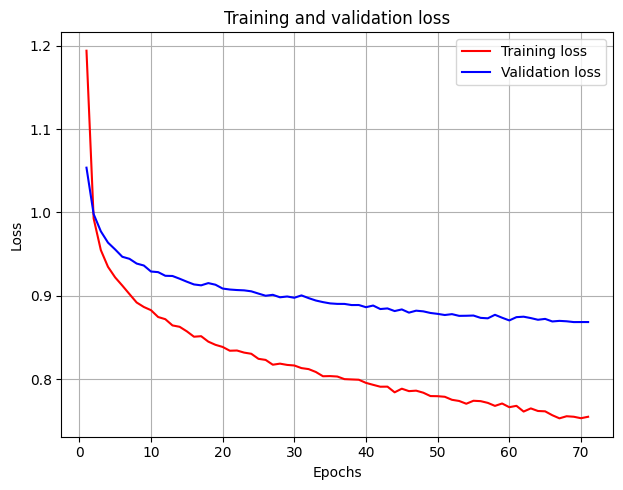

In [36]:
from src.utils.visualization_funcs import visualize_training_results


visualize_training_results(history.history)

In [37]:
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(973, 973, 973)

In [38]:
test_dl = DataLoader(test_image_paths, test_class_ids, test_bboxes, img_size=IMG_SIZE)
test_ds = test_dl.load_val_dataset()
y_true_labels = test_dl.multi_hot_class_ids
y_true_bboxes = test_dl.padded_bbx
test_ds = Preprocessor(test_ds).preprocess()
test_ds = test_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [39]:
results = model.evaluate(test_ds, return_dict=True, steps=1)
results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - bounding_box_iou_metric: 0.5873 - bounding_box_loss: 0.4127 - bounding_box_mae: 0.1788 - bounding_box_mse: 0.0943 - classification_AUC: 0.6200 - classification_f1_score: 0.6258 - classification_loss: 0.3450 - loss: 0.8714


{'bounding_box_iou_metric': 0.5873057246208191,
 'bounding_box_loss': 0.41269421577453613,
 'bounding_box_mae': 0.17884404957294464,
 'bounding_box_mse': 0.09430165588855743,
 'classification_AUC': 0.6200054287910461,
 'classification_f1_score': 0.6257647275924683,
 'classification_loss': 0.3450102210044861,
 'loss': 0.8713528513908386}

In [40]:
from sklearn.metrics import classification_report

y_prob_pred, pred_bbx = model.predict(test_ds)
y_prob_pred[0], pred_bbx[0]

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step


(array([0.9883, 0.6787, 0.99  ], dtype=float16),
 array([[0.609 , 0.6836, 0.7817, 0.8413],
        [0.3699, 0.62  , 0.872 , 0.9336],
        [0.5947, 0.6743, 0.7896, 0.856 ]], dtype=float16))

In [41]:
y_pred = (y_prob_pred>0.5).astype(int)
y_pred[:5]

array([[1, 1, 1],
       [0, 1, 0],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 0]])

In [42]:
report = classification_report(y_true_labels, y_pred, labels=[0,1,2], target_names=CLASS_NAME)
print(report)

              precision    recall  f1-score   support

      label0       0.94      0.85      0.90       588
      label1       1.00      0.89      0.94       962
      label2       0.95      0.78      0.86       554

   micro avg       0.97      0.85      0.91      2104
   macro avg       0.96      0.84      0.90      2104
weighted avg       0.97      0.85      0.91      2104
 samples avg       0.89      0.83      0.84      2104



/code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


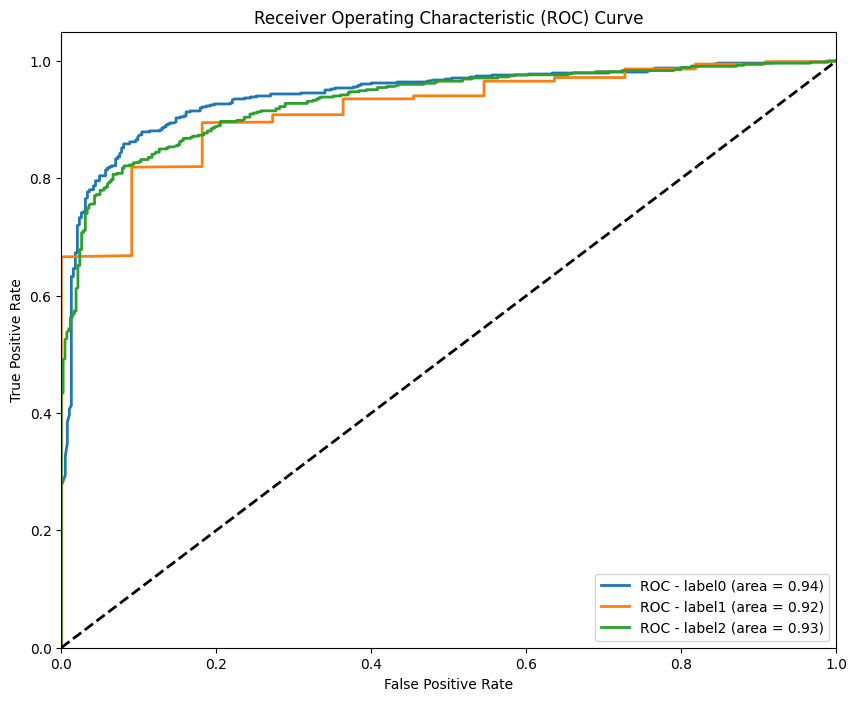

In [43]:
from src.utils.visualization_funcs import plot_auc_curve

plot_auc_curve(OUTPUT_DIR, CLASS_NAME, y_true_labels, y_prob_pred)

In [44]:
test_bboxes[:2], '---------------------------------------', pred_bbx[:2]

([array([[0.61151079, 0.65909091, 0.75539568, 0.82575758],
         [0.36690647, 0.58333333, 0.85611511, 0.98484848],
         [0.58992806, 0.66666667, 0.78417266, 0.84090909]]),
  array([[0.61151079, 0.09848485, 0.99280576, 0.4469697 ]])],
 '---------------------------------------',
 array([[[0.609 , 0.6836, 0.7817, 0.8413],
         [0.3699, 0.62  , 0.872 , 0.9336],
         [0.5947, 0.6743, 0.7896, 0.856 ]],
 
        [[0.6274, 0.1394, 0.9385, 0.446 ],
         [0.644 , 0.1536, 0.943 , 0.4688],
         [0.691 , 0.1624, 0.922 , 0.4067]]], dtype=float16))

In [45]:
from src.losses.iou_loss import iou_metric
def plot_iou_histogram(y_true_bbox, y_pred_bbox, class_ids):
    """
    Plots a histogram of Intersection over Union (IoU) scores.

    Args:
        y_true_bbox: Ground truth bounding boxes (list of lists or numpy array).
        y_pred_bbox: Predicted bounding boxes (list of lists or numpy array).
        class_ids: list of class ids.
    """
    fig, axs = plt.subplots(1)

    iou_scores = iou_metric(y_true_bbox, y_pred_bbox)

    # fig.figure(figsize=(10, 6))
    axs.hist(iou_scores, bins=20, range=(0, 1), edgecolor='black')
    axs.set_title('IoU Score Distribution')
    axs.set_xlabel('IoU Score')
    axs.set_ylabel('Frequency')
    axs.grid(True)
    plt.show()
    plt.savefig(f"{OUTPUT_DIR}/iou_histogram.png")
    return fig


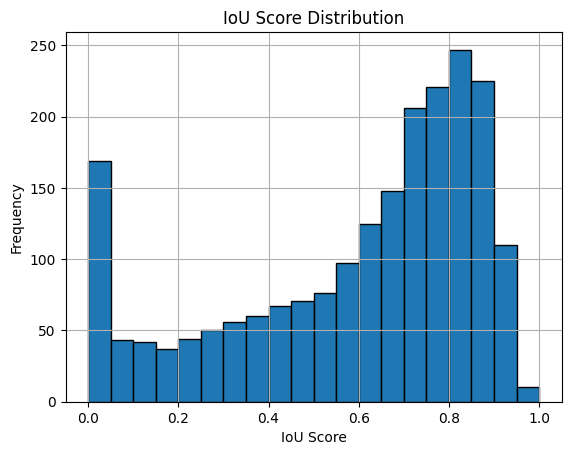

<Figure size 640x480 with 0 Axes>

In [46]:
fig = plot_iou_histogram(y_true_bboxes, pred_bbx, pred_bbx)
mlflow.log_figure(fig, 'iou_histogram.png')